**Modelo de red neuronal ELM**

Este archivo consta de los codigos y conclusiones de:
* 1.Carga de librerias y datos
* 2.Normalizar Datos.
* 3.Preparar datos para realizar aprendizaje supervizado.
* 4.Modelo ELM
* 5.Evaluacion del modelo


#1.Carga de Librerias y Datos


*Se importan los módulos necesarios para trabajar*

In [45]:
#Pandas es utilizado para leer los set de datos
import pandas as pd
#Numpy es utilizado para generar las series de datos a graficar
import numpy as np
#Seaborn es utilizado para generar los gráficos
import seaborn as sns
import matplotlib.pyplot as plt
#Se importan modulos estadisticos para generar test de hipotesis, entre otros
from sklearn.preprocessing import StandardScaler
#Módulos implementa funciones que evalúan el error de predicción para propósitos específicos
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_absolute_percentage_error as mape
from sklearn.metrics import mean_squared_error as mse
#Ignorar warnings
import warnings
warnings.filterwarnings("ignore")

#Dividir arreglos o matrices en subconjuntos aleatorios de tren y prueba
from sklearn.model_selection import train_test_split

#Biblioteca de Redes Neuronales
from keras.models import Sequential
from keras.layers import Dropout, GRU, Dense, Activation,Input
import tensorflow as tf
from tensorflow.keras.optimizers import SGD, Adam, RMSprop
from keras.callbacks import EarlyStopping, ModelCheckpoint

from hyperopt import Trials, STATUS_OK, tpe, hp, fmin, space_eval
from sklearn.model_selection import cross_val_score, KFold, cross_val_predict, TimeSeriesSplit
import time

In [46]:
# Para acceder a los archivos del gdrive
from google.colab import drive
drive.mount('/content/gdrive/')


Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [47]:
cd /content/gdrive/MyDrive/Tesis/Datos-2

/content/gdrive/MyDrive/Tesis/Datos-2


Se obtiene conjunto de datos

In [48]:
df=pd.read_csv('df_EDA.csv',
                parse_dates={'dt':['Date','time']},
                infer_datetime_format=True,
                low_memory=False,
                index_col='dt')

In [49]:
df=df[['Global_active_power','Global_intensity', 'Global_reactive_power', 'Voltage', 'Sub_metering_1', 'Sub_metering_2','Sub_metering_3']]

In [50]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2053263 entries, 2007-01-01 00:00:00 to 2010-11-26 21:02:00
Data columns (total 7 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   Global_active_power    float64
 1   Global_intensity       float64
 2   Global_reactive_power  float64
 3   Voltage                float64
 4   Sub_metering_1         float64
 5   Sub_metering_2         float64
 6   Sub_metering_3         float64
dtypes: float64(7)
memory usage: 125.3 MB


In [51]:
df.shape

(2053263, 7)

In [52]:
## resampling of data over hour
df = df.resample('D').mean()
df.shape

(1426, 7)

In [53]:
#Setear semilla
np.random.seed(42)

#2.Normalizar base de datos

El **método de puntuación z** (a menudo llamado estandarización ) transforma los datos en una distribución con una media de 0 y una desviación estándar de 1 . Cada valor estandarizado se calcula restando la media de la característica correspondiente y luego dividiendo por la desviación estándar.

In [10]:
#Seleccion de caracteristicas
features =df.columns

#Se define escalado
std_scaler = StandardScaler()

#Transformacion

for i in features:
  df[i] = std_scaler.fit_transform(df[i].values.reshape(-1,1))

df.head()

,Global_active_power,Global_intensity,Global_reactive_power,Voltage,Sub_metering_1,Sub_metering_2,Sub_metering_3
dt,,,,,,,
2007-01-01,2.034827,1.981839,-0.579222,-0.344607,-1.006100,-0.715621,-0.877707
2007-01-02,-0.479665,-0.505030,0.254588,0.541014,-1.006100,-0.717544,-0.698740
2007-01-03,-0.913282,-0.919220,0.380838,1.328309,-1.006100,-0.719467,-1.170300
2007-01-04,2.902136,2.905632,0.491035,-0.529403,-0.344237,2.768191,0.438568
2007-01-05,1.974266,1.963020,-0.085215,-0.165616,-0.072187,-0.702637,-0.425828


#3.Preparar datos para realizar aprendizaje supervizado.

La idea es modelar cada valor en función de los valores recientes anteriores, dado un retardo de tiempo dado. **Los valores futuros de una variable en una serie de tiempo dependen de sus propios rezagos y de los rezagos de otras variables.**

In [11]:
def time_delay_embedding(series: pd.Series, n_lags: int, horizon: int):
    """
    Incrustación de retardo de tiempo
    :param series: serie de tiempo como objeto de pandas
    :param n_lags: número de valores pasados para usar como variables explicativas
    :param horizon: horizonte de pronostico
    :return:pd.DataFrame con series temporales reconstruidas
    """
    assert isinstance(series, pd.Series)

    if series.name is None:
        name = 'Series'
    else:
        name = series.name

    n_lags_iter = list(range(n_lags, -horizon, -1))

    serie_time_delay = [series.shift(i) for i in n_lags_iter]
    serie_time_delay = pd.concat(serie_time_delay, axis=1).dropna()
    serie_time_delay.columns = [f'{name}(t-{j - 1})'
                 if j > 0 else f'{name}(t+{np.abs(j) + 1})'
                 for j in n_lags_iter]

    return serie_time_delay

In [12]:
serie_split = []
for columna in df:
  col_df = time_delay_embedding(
      df[columna], #Serie de tiempo
      n_lags=3, #Numero de retrasos
      horizon=1 # Horizonte de prediccion
      )
  serie_split.append(col_df)

In [13]:
serie_df = pd.concat(serie_split, axis=1).dropna()
serie_df.head()

,Global_active_power(t-2),Global_active_power(t-1),Global_active_power(t-0),Global_active_power(t+1),Global_intensity(t-2),Global_intensity(t-1),Global_intensity(t-0),Global_intensity(t+1),Global_reactive_power(t-2),Global_reactive_power(t-1),...,Sub_metering_1(t-0),Sub_metering_1(t+1),Sub_metering_2(t-2),Sub_metering_2(t-1),Sub_metering_2(t-0),Sub_metering_2(t+1),Sub_metering_3(t-2),Sub_metering_3(t-1),Sub_metering_3(t-0),Sub_metering_3(t+1)
dt,,,,,,,,,,,,,,,,,,,,,
2007-01-04,2.034827,-0.479665,-0.913282,2.902136,1.981839,-0.505030,-0.919220,2.905632,-0.579222,0.254588,...,-1.006100,-0.344237,-0.715621,-0.717544,-0.719467,2.768191,-0.877707,-0.698740,-1.170300,0.438568
2007-01-05,-0.479665,-0.913282,2.902136,1.974266,-0.505030,-0.919220,2.905632,1.963020,0.254588,0.380838,...,-0.344237,-0.072187,-0.717544,-0.719467,2.768191,-0.702637,-0.698740,-1.170300,0.438568,-0.425828
2007-01-06,-0.913282,2.902136,1.974266,-0.073304,-0.919220,2.905632,1.963020,-0.014000,0.380838,0.491035,...,-0.072187,-0.164759,-0.719467,2.768191,-0.702637,-0.691578,-1.170300,0.438568,-0.425828,-0.930715
2007-01-07,2.902136,1.974266,-0.073304,1.522701,2.905632,1.963020,-0.014000,1.606520,0.491035,-0.085215,...,-0.164759,0.245206,2.768191,-0.702637,-0.691578,3.047088,0.438568,-0.425828,-0.930715,0.940831
2007-01-08,1.974266,-0.073304,1.522701,1.172214,1.963020,-0.014000,1.606520,1.174003,-0.085215,0.291083,...,0.245206,-1.006100,-0.702637,-0.691578,3.047088,-0.660322,-0.425828,-0.930715,0.940831,2.183893


In [14]:
predictor_variables = serie_df.columns.str.contains('\(t\-')
target_variables = serie_df.columns.str.contains('Global_active_power\(t\+')

In [15]:
predictor_variables = serie_df.iloc[:, predictor_variables]
target_variables = serie_df.iloc[:, target_variables]

In [16]:
#Se separa conjunto en entrenamiento y prueba; sin aleatoriedad
#Dejando un %30 de la data para test
X_train, X_test, Y_train, Y_test = train_test_split(predictor_variables, target_variables, test_size=0.2, shuffle=False)

shape=len(X_train.columns)

print("Separacion de datos terminada!")

Separacion de datos terminada!


In [17]:
X_train.shape

(1138, 21)

#ELM

In [20]:
X_train_a=X_train.to_numpy()
Y_train_a=Y_train.to_numpy()
X_test_a=X_test.to_numpy()
Y_test_a=Y_test.to_numpy()

In [21]:
print(X_train_a.shape)
print(Y_train_a.shape)
print(X_test_a.shape)
print(Y_test_a.shape)

(1138, 21)
(1138, 1)
(285, 21)
(285, 1)


In [22]:
pip install hpelm --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.0/50.0 kB 1.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.7/154.7 kB 5.4 MB/s eta 0:00:00


In [23]:
from hpelm import ELM
from sklearn.model_selection import cross_val_score, KFold
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials

In [24]:
 # Definir la función objetivo
def objective(params):
    n_neurons = int(params['neurons'])
    activation = params['activation']



    #kf = KFold(n_splits=5)
    tscv = TimeSeriesSplit(n_splits=5)
    scores_mse = []
    scores_rmse = []
    scores_mae= []
    scores_mape= []
    times=[]
    models=[]
    #Validacion cruzada
    for train_index, test_index in tscv.split(X_train_a):
      X_train_, X_test_ = X_train_a[train_index], X_train_a[test_index]
      y_train_, y_test_ = Y_train_a[train_index], Y_train_a[test_index]

      # Crear un objeto ELM
      model =ELM(X_train_a.shape[1], 1)

      # Añadir una capa oculta con los hiperparámetros
      model.add_neurons(n_neurons, activation)

      #Entrenamiento
      start = time.time()
      model.train(X_train_, y_train_)
      end = time.time()

      #Evaluacion del modelo
      y_pred = model.predict(X_test_a)
      score_mse = mse(Y_test_a, y_pred)
      rmse = np.sqrt(score_mse)  # Calcular el RMSE
      score_mae = mae(Y_test_a, y_pred)
      score_mape= mape(Y_test_a, y_pred)


      scores_mse.append(score_mse)
      scores_mae.append(score_mae)
      scores_mape.append(score_mape)
      scores_rmse.append(rmse)

      models.append(model)

      #Tiempo de la validadion cruzada
      time_val= end- start
      times.append(time_val)

    return {'loss': np.mean(score_mse),
            'status': STATUS_OK,
            'model': model,
            'params': params,
            'time':times,
            'predic':y_pred,
            'scores_mse': scores_mse,
            'scores_mae': scores_mae,
            'scores_mape': scores_mape,
            'scores_rmse': scores_rmse,
            'models':models
            }

In [25]:
# Definir el espacio de búsqueda de hiperparámetros
space = {
    'neurons': hp.quniform('neurons', 100, 512, 2),
    'activation': hp.choice('activation', ['sigm', 'tanh']),
}

In [ ]:
# Optimización bayesiana
trials = Trials()
best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=100, trials=trials)

print("Los mejores hiperparámetros son: ", best)

# Los resultados completos (incluyendo los scores de validación cruzada para cada evaluación) están en el objeto 'trials'

In [27]:
#Obtener el valor de la función objetivo del mejor ensayo
best_trial = trials.best_trial
predic = best_trial['result']['predic']

In [28]:
# Obtener una lista de los resultados de todas las evaluaciones
all_results = [trial['result'] for trial in trials]


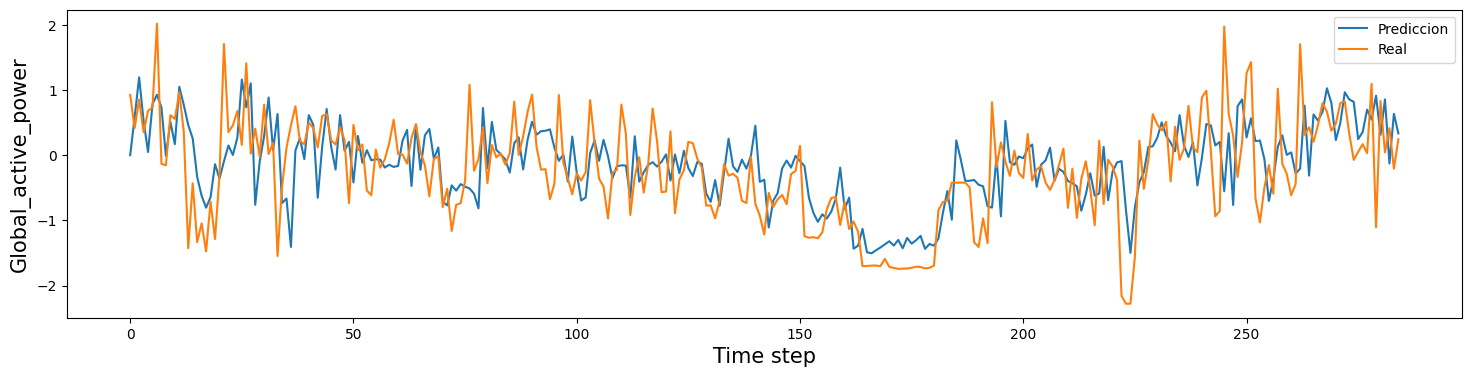

In [29]:
#Grafico de prediccion con el valor real
tiempo=[x for x in range(predic.shape[0])]
plt.figure(figsize=(18,4))
plt.plot(tiempo,predic)
plt.ylabel('Global_active_power', size=15)
plt.plot(tiempo,Y_test)
plt.xlabel('Time step', size=15)
plt.legend(['Prediccion','Real'])
plt.show()

#Exportar resultados

In [30]:
#Del objeto all_results donde estan los resultados de cada trial de la optimizacion bayesiana se obtiene los parametros para exportalos a un csv
results=[]
trial=0 #Nº de intento de optimizacion bayesiana

for result in all_results:
  k=0 #validacion cruzada
  trial+=1
  for time,score_mse,score_mae,score_mape,score_rmse in zip(result['time'],result['scores_mse'],result['scores_rmse'],result['scores_mae'],result['scores_mape']):
    k+=1
    nameModel = "ELM" + "_"+str(result['params']['activation'])+"_"+str(result['params']['neurons'])
    results.append([nameModel,trial,k,time,score_mse,score_rmse,score_mae,score_mape])

In [31]:
#Se crea dataframe
results_csv=pd.DataFrame(results,columns=['nameModel','trial_optimizacion_bayesiana','Step_validacion','time','MSE','RMSE','MAE','MAPE'])

results_o = results_csv.sort_values(by='MSE', ascending=True)
results_o.head(5)

,nameModel,trial_optimizacion_bayesiana,Step_validacion,time,MSE,RMSE,MAE,MAPE
429,ELM_sigm_108.0,86,5,0.008847,0.410243,2.145863,0.640503,0.487136
279,ELM_sigm_120.0,56,5,0.009752,0.414941,2.393076,0.644159,0.486971
319,ELM_sigm_118.0,64,5,0.009939,0.415654,1.796642,0.644712,0.478452
404,ELM_sigm_154.0,81,5,0.021836,0.419943,2.361075,0.648030,0.475267
379,ELM_sigm_148.0,76,5,0.018261,0.428851,2.564600,0.654867,0.491933


In [32]:
# Exportar el DataFrame como CSV
results_csv.to_csv('results_ELM_CE.csv')

#Narmax

In [33]:
 best_model=all_results[85]["models"][4]

In [34]:
predictor_variables=pd.read_csv('predictor_variables.csv', index_col='dt')
target_variables=pd.read_csv('target_variables.csv', index_col='dt')
df=pd.read_csv('df_modelo.csv', index_col='dt')

In [35]:
predictor_variables=predictor_variables.to_numpy()
target_variables=target_variables.to_numpy()


## Generar Narmax data


In [36]:
def narmax_data(data,modelo,predictor,retrasos):
  #Se realiza prediccion
  results = modelo.predict(predictor)
  target = np.array(target_variables)
  error=[]
  aux=0
  for prediccion, real in zip(results,target):
    aux=real-prediccion
    error.append(aux[0])

  df_narmax = data.iloc[retrasos:]
  # Agregamos el arreglo como nueva columna en el DataFrame
  df_narmax['error'] = error

  return df_narmax

In [216]:
df=narmax_data(df,best_model,predictor_variables,3)
df

,Global_active_power,Global_intensity,Global_reactive_power,Voltage,Sub_metering_1,Sub_metering_2,Sub_metering_3,error
dt,,,,,,,,
2006-12-19,0.165544,0.181727,-0.526763,0.566945,-0.478415,2.753617,-0.799143,-0.317429
2006-12-20,1.085635,1.062706,-0.327783,0.717836,-1.006562,0.380121,1.263615,0.172241
2006-12-21,0.249270,0.239930,-0.660841,0.099227,0.104498,0.368143,0.308547,-0.223877
2006-12-22,1.275703,1.294563,0.184862,0.168754,0.976980,-0.720867,0.494736,1.560617
2006-12-23,5.274789,5.385178,0.868785,-0.343654,0.673563,-0.684934,1.437479,3.431725
...,...,...,...,...,...,...,...,...
2010-11-22,0.782730,0.803613,-0.696695,-0.313822,2.049641,0.122362,0.233810,1.510587
2010-11-23,0.019761,0.037690,-0.793731,-0.128886,0.171225,-0.669123,-0.428340,-0.800430
2010-11-24,0.379396,0.366498,-0.892469,-0.395024,-0.316634,0.475942,0.781361,-0.069435


##2.Normalizar base de datos

El **método de puntuación z** (a menudo llamado estandarización ) transforma los datos en una distribución con una media de 0 y una desviación estándar de 1 . Cada valor estandarizado se calcula restando la media de la característica correspondiente y luego dividiendo por la desviación estándar.

In [37]:
#Seleccion de caracteristicas
features =df.columns

#Se define escalado
std_scaler = StandardScaler()

#Transformacion

for i in features:
  df[i] = std_scaler.fit_transform(df[i].values.reshape(-1,1))

df.head()

,Global_active_power,Global_intensity,Global_reactive_power,Voltage,Sub_metering_1,Sub_metering_2,Sub_metering_3
dt,,,,,,,
2006-12-16,4.655893,4.844789,-1.000723,-2.245901,-1.006562,0.062691,2.273157
2006-12-17,3.000804,3.081771,0.958540,-0.367625,0.273203,1.117467,1.074280
2006-12-18,1.049588,1.036582,-0.312072,0.191795,-0.337408,0.367185,1.251815
2006-12-19,0.165544,0.181727,-0.526763,0.566945,-0.478415,2.753617,-0.799143
2006-12-20,1.085635,1.062706,-0.327783,0.717836,-1.006562,0.380121,1.263615


##3.Preparar datos para realizar aprendizaje supervizado.

La idea es modelar cada valor en función de los valores recientes anteriores, dado un retardo de tiempo dado. **Los valores futuros de una variable en una serie de tiempo dependen de sus propios rezagos y de los rezagos de otras variables.**

In [38]:
def time_delay_embedding(series: pd.Series, n_lags: int, horizon: int):
    """
    Incrustación de retardo de tiempo
    :param series: serie de tiempo como objeto de pandas
    :param n_lags: número de valores pasados para usar como variables explicativas
    :param horizon: horizonte de pronostico
    :return:pd.DataFrame con series temporales reconstruidas
    """
    assert isinstance(series, pd.Series)

    if series.name is None:
        name = 'Series'
    else:
        name = series.name

    n_lags_iter = list(range(n_lags, -horizon, -1))

    serie_time_delay = [series.shift(i) for i in n_lags_iter]
    serie_time_delay = pd.concat(serie_time_delay, axis=1).dropna()
    serie_time_delay.columns = [f'{name}(t-{j - 1})'
                 if j > 0 else f'{name}(t+{np.abs(j) + 1})'
                 for j in n_lags_iter]

    return serie_time_delay

In [39]:
serie_split = []
for columna in df:
  col_df = time_delay_embedding(
      df[columna], #Serie de tiempo
      n_lags=3, #Numero de retrasos
      horizon=1 # Horizonte de prediccion
      )
  serie_split.append(col_df)

In [40]:
serie_df = pd.concat(serie_split, axis=1).dropna()
serie_df.head()

,Global_active_power(t-2),Global_active_power(t-1),Global_active_power(t-0),Global_active_power(t+1),Global_intensity(t-2),Global_intensity(t-1),Global_intensity(t-0),Global_intensity(t+1),Global_reactive_power(t-2),Global_reactive_power(t-1),...,Sub_metering_1(t-0),Sub_metering_1(t+1),Sub_metering_2(t-2),Sub_metering_2(t-1),Sub_metering_2(t-0),Sub_metering_2(t+1),Sub_metering_3(t-2),Sub_metering_3(t-1),Sub_metering_3(t-0),Sub_metering_3(t+1)
dt,,,,,,,,,,,,,,,,,,,,,
2006-12-19,4.655893,3.000804,1.049588,0.165544,4.844789,3.081771,1.036582,0.181727,-1.000723,0.958540,...,-0.337408,-0.478415,0.062691,1.117467,0.367185,2.753617,2.273157,1.074280,1.251815,-0.799143
2006-12-20,3.000804,1.049588,0.165544,1.085635,3.081771,1.036582,0.181727,1.062706,0.958540,-0.312072,...,-0.478415,-1.006562,1.117467,0.367185,2.753617,0.380121,1.074280,1.251815,-0.799143,1.263615
2006-12-21,1.049588,0.165544,1.085635,0.249270,1.036582,0.181727,1.062706,0.239930,-0.312072,-0.526763,...,-1.006562,0.104498,0.367185,2.753617,0.380121,0.368143,1.251815,-0.799143,1.263615,0.308547
2006-12-22,0.165544,1.085635,0.249270,1.275703,0.181727,1.062706,0.239930,1.294563,-0.526763,-0.327783,...,0.104498,0.976980,2.753617,0.380121,0.368143,-0.720867,-0.799143,1.263615,0.308547,0.494736
2006-12-23,1.085635,0.249270,1.275703,5.274789,1.062706,0.239930,1.294563,5.385178,-0.327783,-0.660841,...,0.976980,0.673563,0.380121,0.368143,-0.720867,-0.684934,1.263615,0.308547,0.494736,1.437479


In [41]:
predictor_variables = serie_df.columns.str.contains('\(t\-')
target_variables = serie_df.columns.str.contains('Global_active_power\(t\+')

In [42]:
predictor_variables = serie_df.iloc[:, predictor_variables]
target_variables = serie_df.iloc[:, target_variables]

In [43]:
#Se separa conjunto en entrenamiento y prueba; sin aleatoriedad
#Dejando un %30 de la data para test
X_train, X_test, Y_train, Y_test = train_test_split(predictor_variables, target_variables, test_size=0.2, shuffle=False)

shape=len(X_train.columns)

print("Separacion de datos terminada!")

Separacion de datos terminada!


In [44]:
X_train.shape

(1151, 21)

##ELM

In [54]:
X_train_a=X_train.to_numpy()
Y_train_a=Y_train.to_numpy()
X_test_a=X_test.to_numpy()
Y_test_a=Y_test.to_numpy()

In [55]:
print(X_train_a.shape)
print(Y_train_a.shape)
print(X_test_a.shape)
print(Y_test_a.shape)

(1151, 21)
(1151, 1)
(288, 21)
(288, 1)


In [56]:
from hpelm import ELM
from sklearn.model_selection import cross_val_score, KFold
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials

In [57]:
 # Definir la función objetivo
def objective(params):
    n_neurons = int(params['neurons'])
    activation = params['activation']



    #kf = KFold(n_splits=5)
    tscv = TimeSeriesSplit(n_splits=5)
    scores_mse = []
    scores_rmse = []
    scores_mae= []
    scores_mape= []
    times=[]
    models=[]
    #Validacion cruzada
    for train_index, test_index in tscv.split(X_train_a):
      X_train_, X_test_ = X_train_a[train_index], X_train_a[test_index]
      y_train_, y_test_ = Y_train_a[train_index], Y_train_a[test_index]

      # Crear un objeto ELM
      model =ELM(X_train_a.shape[1], 1)

      # Añadir una capa oculta con los hiperparámetros
      model.add_neurons(n_neurons, activation)

      #Entrenamiento
      start = time.time()
      model.train(X_train_, y_train_)
      end = time.time()

      #Evaluacion del modelo
      y_pred = model.predict(X_test_a)
      score_mse = mse(Y_test_a, y_pred)
      rmse = np.sqrt(score_mse)  # Calcular el RMSE
      score_mae = mae(Y_test_a, y_pred)
      score_mape= mape(Y_test_a, y_pred)


      scores_mse.append(score_mse)
      scores_mae.append(score_mae)
      scores_mape.append(score_mape)
      scores_rmse.append(rmse)

      models.append(model)

      #Tiempo de la validadion cruzada
      time_val= end- start
      times.append(time_val)

    return {'loss': np.mean(score_mse),
            'status': STATUS_OK,
            'model': model,
            'params': params,
            'time':times,
            'predic':y_pred,
            'scores_mse': scores_mse,
            'scores_mae': scores_mae,
            'scores_mape': scores_mape,
            'scores_rmse': scores_rmse,
            'models':models
            }

In [58]:
# Definir el espacio de búsqueda de hiperparámetros
space = {
    'neurons': hp.quniform('neurons', 100, 512, 2),
    'activation': hp.choice('activation', ['sigm', 'tanh']),
}

In [59]:
# Optimización bayesiana
trials = Trials()
best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=100, trials=trials)

print("Los mejores hiperparámetros son: ", best)

# Los resultados completos (incluyendo los scores de validación cruzada para cada evaluación) están en el objeto 'trials'

Covariance matrix is not full rank; solving with SVD (slow)
This happened because you have duplicated or too many neurons
Covariance matrix is not full rank; solving with SVD (slow)
This happened because you have duplicated or too many neurons
Covariance matrix is not full rank; solving with SVD (slow)
This happened because you have duplicated or too many neurons
Covariance matrix is not full rank; solving with SVD (slow)
This happened because you have duplicated or too many neurons
Covariance matrix is not full rank; solving with SVD (slow)
This happened because you have duplicated or too many neurons
Covariance matrix is not full rank; solving with SVD (slow)
This happened because you have duplicated or too many neurons
Covariance matrix is not full rank; solving with SVD (slow)
This happened because you have duplicated or too many neurons
Covariance matrix is not full rank; solving with SVD (slow)
This happened because you have duplicated or too many neurons
Covariance matrix is not

In [60]:
#Obtener el valor de la función objetivo del mejor ensayo
best_trial = trials.best_trial
predic = best_trial['result']['predic']

In [61]:
# Obtener una lista de los resultados de todas las evaluaciones
all_results = [trial['result'] for trial in trials]


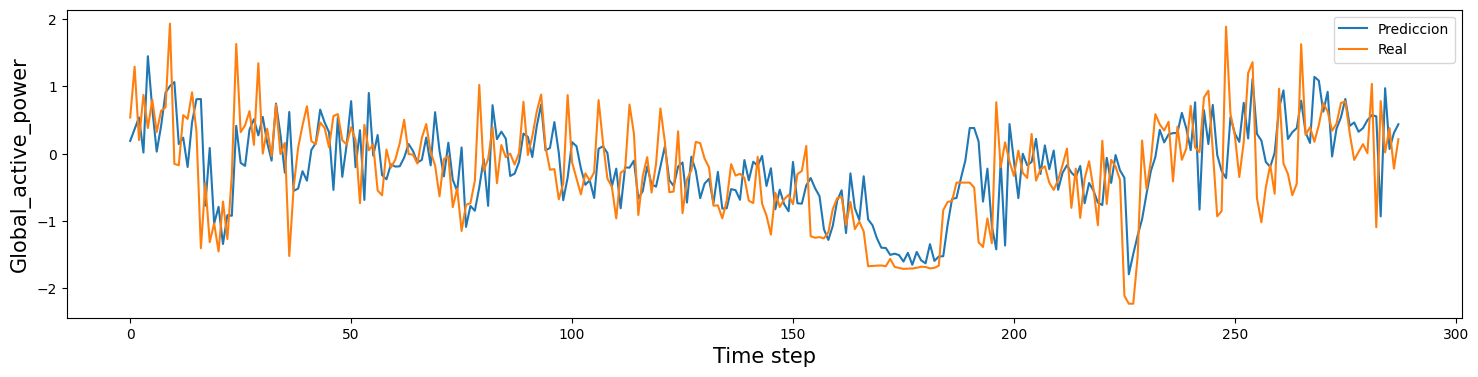

In [62]:
#Grafico de prediccion con el valor real
tiempo=[x for x in range(predic.shape[0])]
plt.figure(figsize=(18,4))
plt.plot(tiempo,predic)
plt.ylabel('Global_active_power', size=15)
plt.plot(tiempo,Y_test)
plt.xlabel('Time step', size=15)
plt.legend(['Prediccion','Real'])
plt.show()

##Exportar resultados

In [63]:
#Del objeto all_results donde estan los resultados de cada trial de la optimizacion bayesiana se obtiene los parametros para exportalos a un csv
results=[]
trial=0 #Nº de intento de optimizacion bayesiana

for result in all_results:
  k=0 #validacion cruzada
  trial+=1
  for time,score_mse,score_mae,score_mape,score_rmse in zip(result['time'],result['scores_mse'],result['scores_rmse'],result['scores_mae'],result['scores_mape']):
    k+=1
    nameModel = "Narmax_ELM" + "_"+str(result['params']['activation'])+"_"+str(result['params']['neurons'])
    results.append([nameModel,trial,k,time,score_mse,score_rmse,score_mae,score_mape])

In [64]:
#Se crea dataframe
results_csv=pd.DataFrame(results,columns=['nameModel','trial_optimizacion_bayesiana','Step_validacion','time','MSE','RMSE','MAE','MAPE'])

results_o = results_csv.sort_values(by='MSE', ascending=True)
results_o.head(5)

,nameModel,trial_optimizacion_bayesiana,Step_validacion,time,MSE,RMSE,MAE,MAPE
334,Narmax_ELM_sigm_112.0,67,5,0.017511,0.376205,4.032922,0.613356,0.459524
139,Narmax_ELM_sigm_102.0,28,5,0.016301,0.378560,4.744431,0.615272,0.454190
19,Narmax_ELM_sigm_104.0,4,5,0.003689,0.379862,4.880875,0.616330,0.451225
144,Narmax_ELM_sigm_112.0,29,5,0.028186,0.398128,4.861078,0.630974,0.463735
214,Narmax_ELM_tanh_100.0,43,5,0.007790,0.403825,5.459772,0.635472,0.491577


In [65]:
# Exportar el DataFrame como CSV
results_csv.to_csv('Narmax_results_ELM_CE.csv')